# Exercise 10

Alissa Trujillo<br>
August 4, 2022<br>
DSC 530<br>
Week 10: Survival Analysis

### Exercise 13-1

In [3]:
import numpy as np
import pandas as pd

In [ ]:
import thinkstats2
import thinkplot

In [ ]:
import empiricaldist

In [28]:
import nsfg
import survival

**Gathering and Cleaning Data**

In [4]:
def CleanData(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [15]:
resp6 = nsfg.ReadFemResp()
resp7 = survival.ReadFemResp2010()

In [16]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

**Resampling the Data**

In [17]:
def ResampleDivorceCurve(resps):
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [19]:
def ResampleDivorceCurveByDecade(resps):
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction of Undivorced Respondents", axis=[0, 28, 0, 1])

**Creating Survival Curves**

In [20]:
def EstimateSurvivalByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [34]:
def EstimateSurvival(resp):
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

**Estimating the Survival Function**

In [36]:
from collections import Counter

def EstimateHazardFunction(complete, ongoing, label='', verbose=False):
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype='float64')
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print('%0.3g\t%d\t%d\t%d\t%0.2g' % 
                  (t, at_risk, ended, censored, lams[t]))
        at_risk -= ended + censored

    return HazardFunction(lams, label=label)

**Plotting Our Findings**

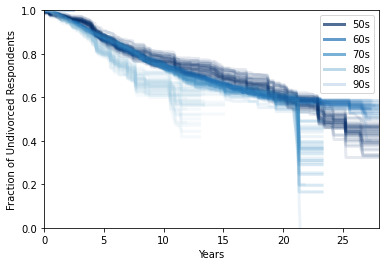

In [38]:
ResampleDivorceCurveByDecade([married6, married7])

We can see a clear downward trend, indicating that the longer the duration of a marriage, the higher likelihood that a respondent is divorced. This makes logical sense, as there is more time to allow for a divorce to happen. The function shows that after 20 years of marriage, those born in the 50's are more likely to get divorced than those born in the 60's and 70's. We can also see the erratic predictions for those born in the 80's and 90's, as those respondents have not had the opportunity to be married as long as they are younger. 